### <font color='red'> Includes and network parameters</font>

In [1]:
import time
import shutil
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
# Network parameters
'''
num_neurons : TYPE list
            DESCRIPTION. list of neurons in each layer.
                This should have a minimum length of 3. 
                First element represents the dimension of input vector.
                Last element represents the dimension of the output vector.
                middle elements represent the number of neurons in hidden layers.
activations : TYPE, option list where each element can be either 'relu' or 'sigmoid' or 'tanh'
            DESCRIPTION. The default is ['relu'].
            If len(activations)==1: 
                same activation function is applied across all hidden layers.
            else:
                len(activations) should be equal to the number of hidden layers.
'''
num_neurons = [2, 100, 2] # list of neurons in each layer of NN. 
activations = ['relu'] # represents the activation function used at the hidden layers.

# optimizer parameters
lr = [1, 0.1, 0.01, 0.001, 0.0001]
lr_step = [500]
weight_decay = 1e-3

#  training parameters
num_epochs = 200
batch_size = 256

# 
print_freq = 1000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### <font color='red'>Create and plot data set</font>

Do not change this cell!

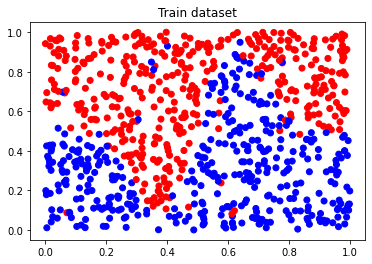

In [3]:
# DO NOT change this cell.
ns = 800
np.random.seed(0)
X_train = np.random.rand(ns,2)
x1 = X_train[:,0]
x2 = X_train[:,1]
y_train = ((np.exp(-((x1-0.5)*6)**2)*2*((x1-0.5)*6)+1)/2-x2)>0 

idx = np.random.choice(range(ns),size=(int(ns*0.03),))
y_train[idx] = ~y_train[idx]

ns = 300
np.random.seed(1)
X_val = np.random.rand(ns,2)
x1 = X_val[:,0]
x2 = X_val[:,1]
y_val = ((np.exp(-((x1-0.5)*6)**2)*2*((x1-0.5)*6)+1)/2-x2)>0 

def plot(X,y,title="Dataset"):
    colors = np.where(y==0, 'r', 'b')
    plt.figure()
    plt.scatter(X[:,0],X[:,1],color=colors)
    plt.title(title)
    plt.show()

plot(X_train,y_train,"Train dataset")
plot(X_val,y_val,"Test dataset")

### <font color='red'>Load data set into Torch dataloader</font>

In [4]:
X_train_tensor = torch.Tensor(X_train) # transform to torch tensor
y_train_tensor = torch.Tensor(y_train)

train_dataset = TensorDataset(X_train_tensor,y_train_tensor) # create your datset
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,drop_last=False)

X_val_tensor = torch.Tensor(X_val) # transform to torch tensor
y_val_tensor = torch.Tensor(y_val)

val_dataset = TensorDataset(X_val_tensor,y_val_tensor) # create your datset
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True,drop_last=False)

### <font color='red'>Model: Feedforward neural network</font>

In [5]:
class LinearNN(nn.Module):
    
    def __init__(self,num_neurons,activations=['relu']):
        '''
        Parameters
        ----------
        num_neurons : TYPE list
            DESCRIPTION. list of neurons in each layer.
                This should have a minimum length of 3. 
                First element represents the dimension of input vector.
                Last element represents the dimension of the output vector.
                middle elements represent the number of neurons in hidden layers.
            
        activations : TYPE, optional list.
            DESCRIPTION. The default is ['relu'].
            If len(activations)==1: 
                same activation function is applied across all hidden layers.
            else:
                len(actiavtions) should be equal to the number of hidden layers.

        Returns
        -------
        None.

        '''
        
        super(LinearNN,self).__init__()
        assert isinstance(num_neurons,list)
        assert np.all([isinstance(neurons,int) for neurons in num_neurons])
        assert np.all([neurons>=1 for neurons in num_neurons])
        assert len(num_neurons)>=3 
        if activations is not None:
            assert isinstance(activations,(list))
            assert (len(activations)==len(num_neurons)-2) or (len(activations)==1)
        
        
        def activation_layer(act_func):
            '''
            

            Parameters
            ----------
            act_func : TYPE should be one from {'relu','sigmoid','tanh'}.
                DESCRIPTION.

            Raises
            ------
            NotImplementedError
                DESCRIPTION.

            Returns
            -------
            TYPE
                DESCRIPTION.

            '''
            if act_func=='relu':
                return nn.ReLU(inplace=True)
            elif act_func=='sigmoid':
                return nn.Sigmoid()
            elif act_func=='tanh':
                return nn.Tanh()
            else:
                raise NotImplementedError
                
        
        layers = []
        for idx,_ in enumerate(num_neurons[:-1]):
            layers.append(nn.Linear(in_features=num_neurons[idx],
                                    out_features=num_neurons[idx+1],
                                    bias=True))
            
            if idx!=len(num_neurons)-2: # add activation for all layers except the last layer.
                if len(activations)==1:
                    layers.append(activation_layer(activations[0]))
                else:
                    layers.append(activation_layer(activations[idx]))
                
        self.network = nn.Sequential(*layers)
            
    
    def forward(self,x):
        x = self.network(x)
        return x

    
def linear_nn(num_neurons,activations=['relu']):
    model = LinearNN(num_neurons,activations)
    return model


### <font color='red'>Define training function</font>

In [6]:
def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        target = target.to(device)
        input_var = torch.autograd.Variable(input).to(device)
        target_var = torch.autograd.Variable(target).to(device)
        # target_var = torch.squeeze(target_var)
        # compute output
        output = model(input_var)
        
        # compute loss
        loss = criterion(output, target_var.long())

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)
        losses.update(loss.item(), input.size(0))
        top1.update(prec1[0][0], input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

#         if i % print_freq == 0:
#             curr_lr = optimizer.param_groups[0]['lr']
#             print('Epoch: [{0}/{1}][{2}/{3}]\t'
#                   'LR: {4}\t'
#                   'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
#                   'Train Acc {top1.val:.3f} ({top1.avg:.3f})'.format(
#                    epoch, num_epochs, i, len(train_loader), curr_lr,
#                    loss=losses, top1=top1))


#     print(' * Train Acc {top1.avg:.3f}'.format(top1=top1))
    # part a
    return top1.avg

### <font color='red'>Define validation and prediction functions</a>

In [7]:
def validate(val_loader, model, criterion):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        target = target.to(device)
        input_var = torch.autograd.Variable(input, volatile=True).to(device)
        target_var = torch.autograd.Variable(target, volatile=True).to(device)

        # compute output
        output = model(input_var)
        # loss = criterion(output, target_var[:,None])
        loss = criterion(output, target_var.long())
        
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)
        losses.update(loss.item(), input.size(0))
        top1.update(prec1[0][0], input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

#         if i % print_freq == 0:
#             print('Test: [{0}/{1}]\t'
#                   'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
#                   'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
#                    i, len(val_loader), loss=losses,
#                    top1=top1))


#     print(' * Test Acc {top1.avg:.3f}'.format(top1=top1))

    return top1.avg

def predict(dataloader,model):
    y_pred = []
    y_true = []
    x = []
    with torch.no_grad():
        for i, (input, target) in enumerate(dataloader):
            # target = target.to(device)
            input_var = torch.autograd.Variable(input, volatile=True).to(device)
            # target_var = torch.autograd.Variable(target, volatile=True).to(device)
    
            # compute output
            output = model(input_var)
            labels = torch.argmax(output,axis=1)
            y_pred.extend(list(labels.data.detach().cpu().numpy()))
            y_true.extend(list(target.numpy()))
            x.extend(list(input_var.data.detach().cpu().numpy()))
    return np.array(x),np.array(y_true),np.array(y_pred)



### <font color='red'>Function to plot the decision boundary of the neural network</font>

In [8]:
def plot_decision_boundary(model):
    h = 0.005
    x_min, x_max = 0,1
    y_min, y_max = 0,1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    x1 = xx.ravel()
    x2 = yy.ravel()
    y = ((np.exp(-((x1-0.5)*6)**2)*2*((x1-0.5)*6)+1)/2-x2)>0 
    
    X_train_tensor = torch.Tensor(np.c_[xx.ravel(), yy.ravel()]) # transform to torch tensor
    y_train_tensor = torch.Tensor(y)
    
    dataset = TensorDataset(X_train_tensor,y_train_tensor) # create your datset
    dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=False,drop_last=False)

    
    x,y_true,y_pred = predict(dataloader,model)
    Z = y_pred.reshape(xx.shape)
    plt.figure()
    plt.contourf(x[:,0].reshape(xx.shape), x[:,1].reshape(xx.shape), Z, cmap=plt.cm.Paired)
    plt.axis('tight')
    
    # scatter plot of data points with colors corresponding to the correct labels. 
    ns = 500
    np.random.seed(0)
    X_test = np.random.rand(ns,2)
    x1 = X_test[:,0]
    x2 = X_test[:,1]
    y_test = ((np.exp(-((x1-0.5)*6)**2)*2*((x1-0.5)*6)+1)/2-x2)>0 
    colors = np.where(y_test==0, 'r', 'b')
    plt.scatter(x1,x2,color=colors)
    # plt.scatter(x[:,0],x[:,1],colors=)
    plt.show()

### <font color='red'>Functions to track the model performance and save the desired model state</font>

In [9]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

### <font color='red'>Create model instance; define loss function and optimizer</font> 

In [10]:
torch.manual_seed(999)
models = []

for i in range(len(lr)):
    models.append(linear_nn(num_neurons,activations).to(device))
    
# define loss function (criterion) and optimizer
# criterion = nn.BCEWithLogitsLoss().to(device) 
criterion = nn.CrossEntropyLoss().to(device)

optimizers = []

for i, rate in enumerate(lr):
    optimizers.append(torch.optim.Adam(models[i].parameters(),lr=rate, weight_decay=weight_decay))

### <font color='red'>Train model and validate</font>

/var/folders/fd/qmhdtpdj7kj77ftrqfj87hmc0000gn/T/ipykernel_8038/108805674.py:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_var = torch.autograd.Variable(input, volatile=True).to(device)
/var/folders/fd/qmhdtpdj7kj77ftrqfj87hmc0000gn/T/ipykernel_8038/108805674.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  target_var = torch.autograd.Variable(target, volatile=True).to(device)
/var/folders/fd/qmhdtpdj7kj77ftrqfj87hmc0000gn/T/ipykernel_8038/108805674.py:48: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_var = torch.autograd.Variable(input, volatile=True).to(device)


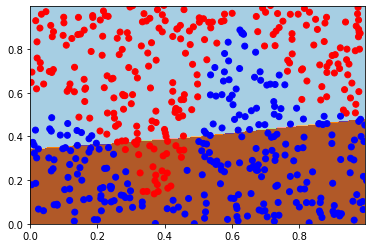

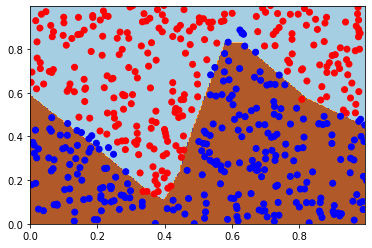

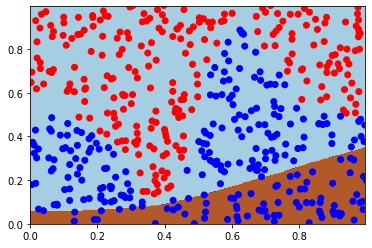

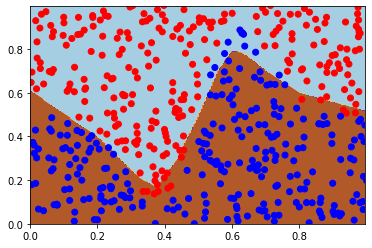

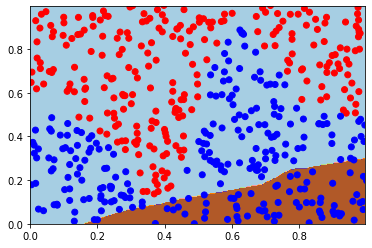

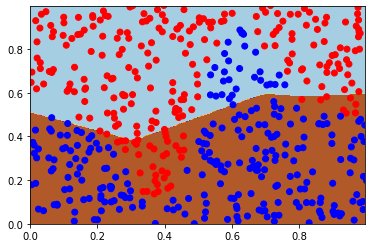

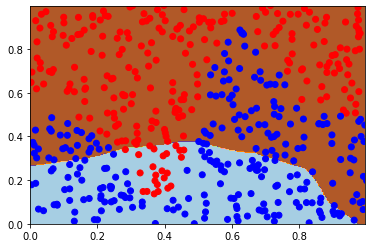

In [11]:
train_losses = [[],[],[],[],[]]
validate_losses = [[],[],[],[],[]]

for i in range(len(optimizers)):
    best_prec1 = 0
    for epoch in range(num_epochs):
        if epoch in lr_step:
            for param_group in optimizers[i].param_groups:
                param_group['lr'] *= 0.1

        # train for one epoch
        train1 = train(train_loader, models[i], criterion, optimizers[i], epoch)

        # evaluate on validation set
        # prec1 = 0
        prec1 = validate(val_loader, models[i], criterion)

        ## part a
        train_losses[i].append(train1)
        validate_losses[i].append(prec1)

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': models[i].state_dict(),
            'best_prec1': best_prec1,
            'optimizer': optimizers[i].state_dict(),
        }, is_best,filename="checkpoint.pth.tar")
        # print("-----------------------------------------------")

        if epoch%print_freq==0:
            plot_decision_boundary(models[i])

    plot_decision_boundary(models[i])

## Neural Net Problem 2

In [12]:
validate_losses = np.array([[item.item() for item in row] for row in validate_losses])
train_losses = np.array([[item.item() for item in row] for row in train_losses])
epochs_count = range(num_epochs)

In [13]:
epochs_count

range(0, 200)

### Part C

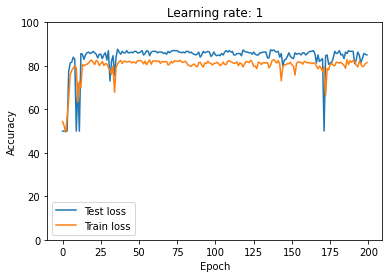

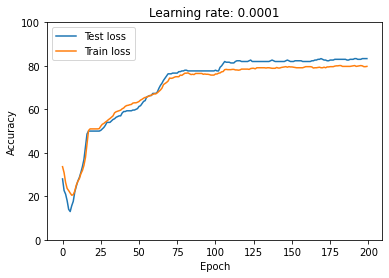

In [14]:
for i in range(len(optimizers)):
    plt.plot(epochs_count, validate_losses[i], label='Test loss')
    plt.plot(epochs_count, train_losses[i], label='Train loss')
    plt.xlabel('Epoch')
    plt.ylim(0,100)
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'Learning rate: {lr[i]}')
    plt.show()

In [15]:
for i in range(len(optimizers)):
    print(f'Learning rate: {lr[i]}')
    print(f'Final test accuracy: {validate_losses[i][-1]}')
    print(f'Final train accuracy: {train_losses[i][-1]}')
    
    total_params = sum(p.numel() for p in models[i].parameters())
    print(f"Total parameters: {total_params}")
    print("------")

Learning rate: 1
Final test accuracy: 85.0
Final train accuracy: 81.5
Total parameters: 502
------
Learning rate: 0.1
Final test accuracy: 95.33333587646484
Final train accuracy: 93.0
Total parameters: 502
------
Learning rate: 0.01
Final test accuracy: 93.0
Final train accuracy: 92.125
Total parameters: 502
------
Learning rate: 0.001
Final test accuracy: 87.33333587646484
Final train accuracy: 84.25
Total parameters: 502
------
Learning rate: 0.0001
Final test accuracy: 83.33333587646484
Final train accuracy: 79.75
Total parameters: 502
------


Given that this model does slightly better under a shallow learning net, this is the ideal for this dataset and parameters. Shallow networks with fewer layers are often simpler and easier to interpret.